In [ ]:
import pandas as pd
import numpy as np
import regex as re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
df_train = pd.read_csv("train.csv", encoding='unicode_escape')
df_train["content"] = df_train["text"]
df_test = pd.read_csv("summarized_test.csv")
df_train['content'] = df_train['content'].astype(str)
df_test['content'] = df_test['summary'].astype(str)

In [ ]:
print("Train set length:", len(df_train))
print("Test set length:", len(df_test))

Train set length: 27481
Test set length: 1000


### Partitioning

In [ ]:
def partition(x):
    if x == "negative":
        return 0
    elif x == "neutral":
        return 2
    else:
        return 1

actualScore = df_train['sentiment']
class_ = actualScore.map(partition)
df_train['ratings_class'] = class_
df_train.ratings_class.value_counts()

ratings_class
2    11118
1     8582
0     7781
Name: count, dtype: int64

In [ ]:
def partition(x):
    if x < 3:
        return 2
    elif x == 3:
        return 0
    else:
        return 1

actualScore = df_test['rating']
class_ = actualScore.map(partition)
df_test['ratings_class'] = class_
df_test.ratings_class.value_counts()

ratings_class
1    896
2     64
0     40
Name: count, dtype: int64

### Stemming

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def stemming(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    output = ''

    for i in x:
        output += stemmer.stem(i) + ' '

    return output

In [ ]:
df_train['content'] = df_train['content'].apply(stemming)
df_test['content'] = df_test['content'].apply(stemming)

### Lemmatization

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

In [ ]:
df_train['content'] = get_lemmatized_text(df_train['content'])
df_test['content'] = get_lemmatized_text(df_test['content'])

### Removal of Stopwords

In [ ]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d"]
stop = set(stop + additional_stopwords)
def remove_stop(x):
    x = word_tokenize(x)
    store = ''

    for i in x:
        if i not in stop:
            store += i + ' '

    return store

In [ ]:
df_train['content'] = df_train['content'].apply(remove_stop)
df_test['content'] = df_test['content'].apply(remove_stop)

### Wordcount

In [ ]:
wordcount = df_train['content'].apply(lambda x: len(x.split())).sum()
print("There are {} words in the corpus.".format(wordcount))

There are 274428 words in the corpus.


In [ ]:
df_train.content.str.split(expand=True).stack().value_counts()

!                       15296
.                       13910
`                       11614
,                        8461
*                        4953
                        ...  
kaila                       1
//tinyurl.com/64ozr7        1
weeaboo                     1
boo-hoo                     1
atg                         1
Name: count, Length: 23257, dtype: int64

## Naive Bayes Classification

In [ ]:
from sklearn.model_selection import train_test_split

import time

x_train, x_test, y_train, y_test = df_train[df_train.ratings_class != 2][["content"]], df_test[df_test.Subjectivity == 0][["content"]], \
        df_train[df_train.ratings_class != 2]["ratings_class"], df_test[df_test.Subjectivity == 0]["Positivity"]

start_time = time.time()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, sublinear_tf=True)
comment_matrix = vectorizer.fit_transform(x_train['content'])

from sklearn.naive_bayes import MultinomialNB
comment_classifier = MultinomialNB().fit(comment_matrix, y_train)
print("--- Training time: %s seconds ---" % (time.time() - start_time))

from sklearn import metrics
test_vector = vectorizer.transform(x_test['content'])

start_time = time.time()
result = comment_classifier.predict(test_vector)
print("--- Evaluating time: %s seconds ---" % (time.time() - start_time))
confuse = metrics.confusion_matrix(y_test, result)
confuse


--- Training time: 0.9800238609313965 seconds ---
--- Evaluating time: 0.0009696483612060547 seconds ---


array([[ 39,  32],
       [249, 548]])

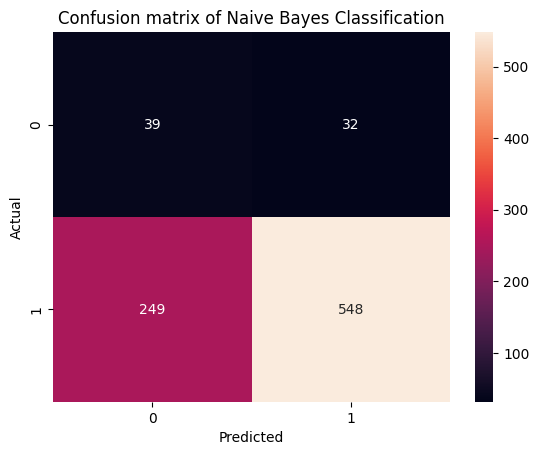

In [ ]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Naive Bayes Classification")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
F1_score = metrics.f1_score(y_test, result)
average_precision = metrics.average_precision_score(y_test, result)
precision_score= metrics.precision_score(y_test, result)
recall_score = metrics.recall_score(y_test, result)

print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))
print('Average precision-recall score: {0:0.3f}'.format(
      average_precision))

F1 score: 0.796
Precision score: 0.945
Recall score: 0.688
Average precision-recall score: 0.937


## KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

metrics = ['euclidean', 'manhattan', 'cosine']
neighbors = list(range(1,10))
leaf_size = list(range(1,10))
weight = ['uniform', 'distance']
param_grid = {'metric' : metrics, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

{'leaf_size': 1,
 'metric': 'euclidean',
 'n_neighbors': 4,
 'weights': 'distance'}

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=4, metric='euclidean', leaf_size=1, weights='distance')
knn_model.fit(comment_matrix, y_train)
print("--- Training time: %s seconds ---" % (time.time() - start_time))

test_vector = vectorizer.transform(x_test['content'])
start_time = time.time()

result = knn_model.predict(test_vector)
print("--- Evaluating time: %s seconds ---" % (time.time() - start_time))

confuse = metrics.confusion_matrix(y_test, result)
confuse

--- Training time: 0.021318674087524414 seconds ---
--- Evaluating time: 3.755797863006592 seconds ---


array([[ 47,  24],
       [369, 428]])

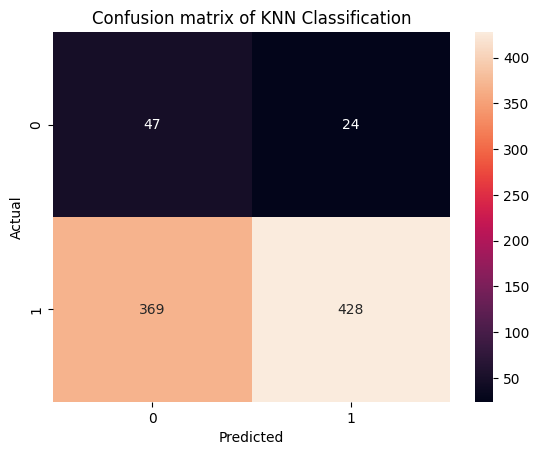

In [ ]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of KNN Classification")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
F1_score = metrics.f1_score(y_test, result)
average_precision = metrics.average_precision_score(y_test, result)
precision_score= metrics.precision_score(y_test, result)
recall_score = metrics.recall_score(y_test, result)

print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))
print('Average precision-recall score: {0:0.3f}'.format(average_precision))

F1 score: 0.685
Precision score: 0.947
Recall score: 0.537
Average precision-recall score: 0.934


## SVM

In [ ]:
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV
# nfolds=3

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
# degrees = [0, 1, 2, 3, 4, 5, 6]
# kernels = ['rbf', 'linear', 'poly']
# param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}

# grid_search = GridSearchCV(svm.SVC(), param_grid, cv = nfolds)
# grid_search.fit(test_vector, y_test)
# grid_search.best_params_
print('''{'C': 0.001, 'degree': 0, 'gamma': 0.05, 'kernel': 'rbf'}''')

{'C': 1, 'degree': 3, 'gamma': 0.05, 'kernel': 'linear'}


In [ ]:
from sklearn import svm
start_time = time.time()
SVM = svm.SVC(C=0.001, kernel='rbf', gamma=0.05, degree=0).fit(comment_matrix, y_train)
print("--- Training time: %s seconds ---" % (time.time() - start_time))

test_vector = vectorizer.transform(x_test['content'])
start_time = time.time()
result = SVM.predict(test_vector)
print("--- Evaluating time: %s seconds ---" % (time.time() - start_time))

confuse = metrics.confusion_matrix(y_test, result)
confuse

--- Training time: 42.771034717559814 seconds ---
--- Evaluating time: 1.2503111362457275 seconds ---


array([[  0,  71],
       [  0, 797]])

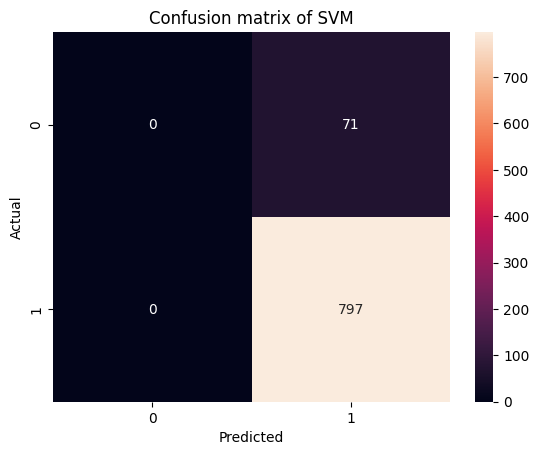

In [ ]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of SVM")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
F1_score = metrics.f1_score(y_test, result)
average_precision = metrics.average_precision_score(y_test, result)
precision_score= metrics.precision_score(y_test, result)
recall_score = metrics.recall_score(y_test, result)

print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))
print('Average precision-recall score: {0:0.3f}'.format(average_precision))

F1 score: 0.957
Precision score: 0.918
Recall score: 1.000
Average precision-recall score: 0.918
